Following notes from this page: https://medium.com/modern-physics/finite-difference-solution-of-the-schrodinger-equation-c49039d161a8

In [24]:
# import libraries
import numpy as np
import sys
import psi4
from helper_PFCI import PFHamiltonianGenerator
np.set_printoptions(threshold=sys.maxsize)
import scipy
from scipy.optimize import curve_fit
from scipy import interpolate
from matplotlib import pyplot as plt
from scipy import constants
from numpy.polynomial import Polynomial

In [25]:
# z-matrix for LiH
mol_str_LiH = """
Li
H 1 1.546938775510204
symmetry c1
"""

# options for the PFHamiltonian Generator class - include cavity effects
cavity_dict = {
    'omega_value' : 0.12086,
    'lambda_vector' : np.array([0, 0, 0.005]),
    'ci_level' : 'fci',   
    'full_diagonalization' : True,
    'number_of_photons' : 1, #<== this is a minimal photon basis, should explore increasing this 
}

# options for PFHamiltonian Generator class - exclude cavity effects
cavity_free_dict = {
    'omega_value' : 0.0,
    'lambda_vector' : np.array([0, 0, 0.0]),
    'ci_level' : 'fci',   
    'full_diagonalization' : True,
    'number_of_photons' : 0, 
}

In [26]:
mol_tmpl = """
Li
H 1 **R**
symmetry c1
"""
options_dict = {
    "basis": "sto-3g",
    "scf_type": "pk",
    "e_convergence": 1e-10,
    "d_convergence": 1e-10,
    'num_roots' : 2
}

# number of bondlengths in the scan
N_R = 50

# number of electronic states to save
N_el = 10

# array  for energies inside the cavity
cavity_E_array_LiH = np.zeros((N_R, N_el))

r_data = np.linspace(1.2, 2.0, 50)
psi4.set_options(options_dict)
fci_S0 = []
fci_S1 = []
r_idx_LiH = 0
for r in r_data:
    mol_str = mol_tmpl.replace("**R**", str(r))
    mol = psi4.geometry(mol_str)
    scf_e, wfn = psi4.energy('SCF', return_wfn=True)
    fci_energy, wfn = psi4.energy('fci',ref_wfn=wfn, return_wfn=True)
    fci_S0.append(wfn.variable("CI ROOT 0 TOTAL ENERGY"))
    fci_S1.append(wfn.variable("CI ROOT 1 TOTAL ENERGY"))
    LiH_cav = PFHamiltonianGenerator(mol_str, options_dict, cavity_dict)
    cavity_E_array_LiH[r_idx_LiH,:] = LiH_cav.CIeigs[:N_el]
    r_idx_LiH += 1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEM92KWMALT
*** at Fri Jan 26 15:29:14 2024

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/anaconda3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/anaconda3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> 

Min on S0 is 1.5428571428571427
Min on S1 is 1.853061224489796
Min on LP is 1.5428571428571427
Min on UP is 1.7714285714285714
148.390843073308
44.790945881691336
153.33396540682688
164.52028086372889


<function matplotlib.pyplot.show(close=None, block=None)>

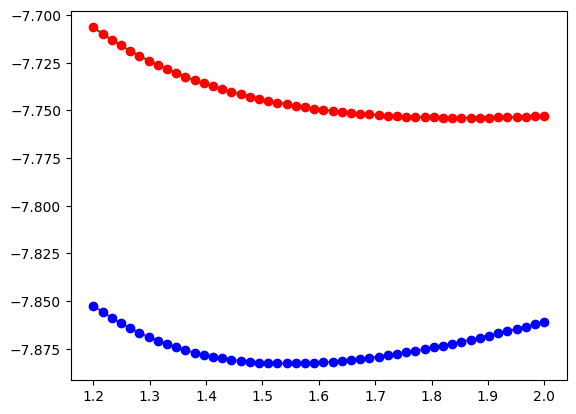

In [15]:
au_to_SI = (4.35974 * 10 ** (-18)) * 10 ** 20
LP_array_1 = cavity_E_array_LiH[20:,2]
LP_array_2 = cavity_E_array_LiH[:20,1]
LP_array_full = np.concatenate((LP_array_2, LP_array_1), axis=0)
min_S0_loc = np.argmin(fci_S0[:])
min_S1_loc = np.argmin(fci_S1[:])
min_LP_loc = np.argmin(LP_array_full[:])
min_UP_loc = np.argmin(cavity_E_array_LiH[:,3])
r_eq_ang = r_data[min_S0_loc]
r_eq_S1_ang = r_data[min_S1_loc]
r_eq_LP_ang = r_data[min_LP_loc]
r_eq_UP_ang = r_data[min_UP_loc]
print(f'Min on S0 is {r_data[min_S0_loc]}')
print(f'Min on S1 is {r_data[min_S1_loc]}')
print(f'Min on LP is {r_data[min_LP_loc]}')
print(f'Min on UP is {r_data[min_UP_loc]}')

mu_amu = 1.00784 * 6.9410 / (1.00784 + 6.9410)
mu_kg = mu_amu  * 10 ** (-3) / (6.022 * 10 ** 23) 
r_eq_SI = r_eq_ang * 10 ** (-10)
r_eq_S1_SI = r_eq_S1_ang * 10 ** (-10)

# Fitting S0 PES to a quintic polynomial
poly = np.poly1d(np.polyfit(r_data, fci_S0, 5))
poly_e = np.poly1d(np.polyfit(r_data, fci_S1, 5))
poly_LP = np.poly1d(np.polyfit(r_data, LP_array_full, 5))
poly_UP = np.poly1d(np.polyfit(r_data, cavity_E_array_LiH[:,3], 5))

#Taking first and second derivative of S0 PES and evaluating at r_eq
first_derivative = poly.deriv()
second_derivative = first_derivative.deriv()
k_test_au = second_derivative(r_eq_ang)
k_test_SI = k_test_au * au_to_SI
print(k_test_SI)

first_derivative_S1 = poly_e.deriv()
second_derivative_S1 = first_derivative_S1.deriv()
k_test_S1_au = second_derivative_S1(r_eq_S1_ang)
k_test_S1_SI = k_test_S1_au * au_to_SI
print(k_test_S1_SI)

first_derivative_LP = poly_LP.deriv()
second_derivative_LP = first_derivative_LP.deriv()
k_test_LP_au = second_derivative_LP(r_eq_LP_ang)
k_test_LP_SI = k_test_LP_au * au_to_SI
print(k_test_LP_SI)

first_derivative_UP = poly_UP.deriv()
second_derivative_UP = first_derivative_UP.deriv()
k_test_UP_au = second_derivative_UP(r_eq_UP_ang)
k_test_UP_SI = k_test_UP_au * au_to_SI
print(k_test_UP_SI)




#plotting S0 PES and quintic fit
plt.plot(r_data, poly(r_data), 'm-', label='fit')
plt.plot(r_data, fci_S0[:], 'bo', label='cavity free |g>')
plt.plot(r_data, poly_e(r_data), 'g-', label='fit')
plt.plot(r_data, fci_S1[:], 'ro', label='cavity free |e>')
plt.show

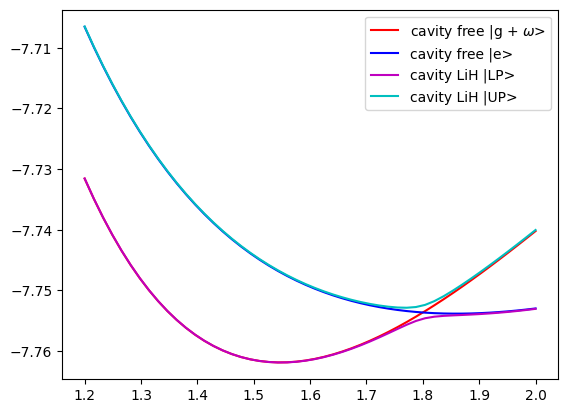

In [16]:
fci_S0_omega = np.zeros((1, 50))
for i in range(50):
    fci_S0_omega[0,i] = fci_S0[i] + 0.12086
fci_S0_plusw = np.ndarray.flatten(fci_S0_omega)




plt.plot(r_data, fci_S0_plusw, 'r-', label='cavity free |g + $\omega$>')
plt.plot(r_data, fci_S1, 'b-', label='cavity free |e>')
plt.plot(r_data, LP_array_full, 'm-', label='cavity LiH |LP>')
#plt.plot(r_data, cavity_E_array_LiH[:,1], 'g-', label='cavity LiH |TRIPLET>')
plt.plot(r_data, cavity_E_array_LiH[:,3], 'c-', label='cavity LiH |UP>')
#plt.xlim(0.6, 1.45)
plt.legend()
plt.show()

## Ground Electronic State

In [17]:
angstrom_to_bohr = 1.88973
x_min = 0.5 * 10 ** (-10)
x_max = 3.0 * 10 ** (-10)

hbar = scipy.constants.hbar
r_eq_SI = r_eq_ang * 10 ** (-10)
r_eq_au = r_eq_ang * angstrom_to_bohr

# number of grid points 
N = 1001

# define grid
x = np.linspace(x_min, x_max, N)

# define grid spacing h
h = x[1]-x[0]

def Vpot(x):
    return  1/2 * k_test_SI * (x - r_eq_SI) ** 2

V_x = Vpot(x)

# create arrays for T, V, and H - we truncate the smallest and largest grid points where 
# the centered finite difference derivatives cannot be defined
T = np.zeros((N-2, N-2))
V = np.zeros((N-2, N-2))
H = np.zeros((N-2, N-2))

# this uses the 3 point stencil; we can adapt to use a 5 point and it might improve accuracy
for i in range(N-2):
    for j in range(N-2):
        if i==j:
            T[i,j]= -2
        elif np.abs(i-j)==1:
            T[i,j]=1
        else:
            T[i,j]=0



for i in range(N-2):
    for j in range(N-2):
        if i==j:
            V[i,j]= Vpot(x[i+1])
        else:
            V[i,j]=0
            
H = -T * hbar ** 2 / (2 * mu_kg * h**2) + V

vals, vecs = np.linalg.eigh(H)
print(vals[0])
print(vecs[0,:])

1.6801871564346434e-20
[-8.28294778e-13  7.93614692e-12  5.31562558e-11 -2.87277659e-10
  1.32808232e-09  5.42144736e-09 -1.99338528e-08  6.69110108e-08
  2.07017444e-07 -5.94559495e-07 -1.59356015e-06  4.00180761e-06
 -9.44340994e-06 -2.09826727e-05  4.39492990e-05  8.67979586e-05
 -1.61509598e-04  2.82616545e-04  4.63734838e-04 -7.11400106e-04
 -1.01881850e-03  1.36492589e-03  1.72168445e-03 -2.06483870e-03
 -2.38022431e-03  2.66334995e-03  2.91567715e-03 -3.14114168e-03
 -3.34410775e-03  3.52849396e-03  3.69753556e-03 -3.85381475e-03
 -3.99937861e-03  4.13588161e-03  4.26476056e-03 -4.38750171e-03
 -4.50607932e-03  4.62352456e-03  4.74418403e-03  4.87284440e-03
 -5.01260303e-03 -5.16318713e-03  5.32152472e-03  5.48382957e-03
  5.64717798e-03 -5.80987735e-03 -5.97116383e-03  6.13080420e-03
  6.28881783e-03 -6.44532414e-03 -6.60046989e-03  6.75439841e-03
  6.90723851e-03 -7.05910200e-03 -7.21008463e-03  7.36026804e-03
  7.50972202e-03  7.65850641e-03 -7.80667282e-03 -7.95426601e-03
  

## Excited Electronic State

In [18]:

r_eq_S1_SI = r_eq_S1_ang * 10 ** (-10)
r_eq_S1_au = r_eq_S1_ang * angstrom_to_bohr

def Vpot_e(x):
    return  1/2 * k_test_S1_SI * (x - r_eq_S1_SI) ** 2

V_x_e = Vpot_e(x)

# create arrays for T, V, and H - we truncate the smallest and largest grid points where 
# the centered finite difference derivatives cannot be defined
T_e = np.zeros((N-2, N-2))
V_e = np.zeros((N-2, N-2))
H_e = np.zeros((N-2, N-2))

# this uses the 3 point stencil; we can adapt to use a 5 point and it might improve accuracy
for i in range(N-2):
    for j in range(N-2):
        if i==j:
            T_e[i,j]= -2
        elif np.abs(i-j)==1:
            T_e[i,j]=1
        else:
            T_e[i,j]=0



for i in range(N-2):
    for j in range(N-2):
        if i==j:
            V_e[i,j]= Vpot_e(x[i+1])
        else:
            V_e[i,j]=0
            
H_e = -T_e * hbar ** 2 /(2 * mu_kg * h**2) + V_e

vals_e, vecs_e = np.linalg.eigh(H_e)
print(vals_e[0])
print(vecs_e[0,:])

9.231081855910755e-21
[ 3.07406928e-12 -2.82846964e-11 -1.81741170e-10  9.41162192e-10
  4.16403820e-09  1.62459628e-08 -5.70056182e-08 -1.82310933e-07
  5.36476467e-07  1.46293321e-06 -3.71856225e-06 -8.85973156e-06
  1.99008322e-05  4.23560228e-05 -8.55772239e-05 -1.63593038e-04
  2.93471281e-04  4.88785974e-04 -7.49181875e-04 -1.05483601e-03
  1.37499912e-03  1.68408636e-03 -1.96984780e-03 -2.23070518e-03
  2.46995136e-03  2.69192077e-03 -2.90045060e-03  3.09854166e-03
  3.28844284e-03 -3.47182460e-03 -3.64993547e-03  3.82372043e-03
  3.99390541e-03 -4.16105661e-03 -4.32562202e-03  4.48796097e-03
  4.64836518e-03 -4.80707418e-03 -4.96428663e-03  5.12016879e-03
  5.27486099e-03 -5.42848257e-03 -5.58113568e-03  5.73290834e-03
  5.88387682e-03 -6.03410754e-03 -6.18365864e-03  6.33258122e-03
  6.48092038e-03 -6.62871609e-03 -6.77600386e-03  6.92281538e-03
  7.06917899e-03 -7.21512010e-03 -7.36066156e-03  7.50582397e-03
  7.65062594e-03 -7.79508429e-03 -7.93921430e-03  8.08302982e-03
  8

## Lower Polariton Surface

In [19]:
r_eq_LP_SI = r_eq_LP_ang * 10 ** (-10)
r_eq_LP_au = r_eq_LP_ang * angstrom_to_bohr

def Vpot_LP(x):
    return  1/2 * k_test_LP_SI * (x - r_eq_LP_SI) ** 2

V_x_LP = Vpot_LP(x)

# create arrays for T, V, and H - we truncate the smallest and largest grid points where 
# the centered finite difference derivatives cannot be defined
T_LP = np.zeros((N-2, N-2))
V_LP = np.zeros((N-2, N-2))
H_LP = np.zeros((N-2, N-2))

# this uses the 3 point stencil; we can adapt to use a 5 point and it might improve accuracy
for i in range(N-2):
    for j in range(N-2):
        if i==j:
            T_LP[i,j]= -2
        elif np.abs(i-j)==1:
            T_LP[i,j]=1
        else:
            T_LP[i,j]=0



for i in range(N-2):
    for j in range(N-2):
        if i==j:
            V_LP[i,j]= Vpot_LP(x[i+1])
        else:
            V_LP[i,j]=0
            
H_LP = -T_LP * hbar ** 2 /(2 * mu_kg * h**2) + V_LP

vals_LP, vecs_LP = np.linalg.eigh(H_LP)
print(vals_LP[0])
print(vecs_LP[0,:])

1.7079422002047478e-20
[-5.68903442e-13  5.49755403e-12  3.71458145e-11 -2.02557977e-10
  9.45080325e-10  3.89465111e-09 -1.44603263e-08  4.90291477e-08
  1.53279734e-07 -4.45003176e-07 -1.20619386e-06  3.06481438e-06
 -7.32201213e-06 -1.64823327e-05  3.50055019e-05  7.01756841e-05
 -1.32729182e-04  2.36489467e-04  3.95921035e-04 -6.20891866e-04
 -9.10016795e-04  1.24717082e-03  1.60577314e-03 -1.95908337e-03
 -2.28879963e-03  2.58701361e-03 -2.85329961e-03 -3.09091634e-03
  3.30420141e-03  3.49730222e-03  3.67373786e-03 -3.83634872e-03
 -3.98738794e-03  4.12865065e-03  4.26161836e-03 -4.38764929e-03
 -4.50828752e-03  4.62575219e-03  4.74346789e-03  4.86604180e-03
 -4.99793628e-03 -5.14125793e-03  5.29469358e-03  5.45473131e-03
 -5.61774554e-03 -5.78118819e-03 -5.94368239e-03  6.10465381e-03
  6.26396251e-03 -6.42166652e-03 -6.57789747e-03  6.73280296e-03
  6.88652292e-03 -7.03918162e-03 -7.19088643e-03  7.34172920e-03
  7.49178828e-03  7.64113073e-03 -7.78981412e-03 -7.93788822e-03
  

## Upper Polariton Surface

In [20]:
r_eq_UP_SI = r_eq_UP_ang * 10 ** (-10)
r_eq_UP_au = r_eq_UP_ang * angstrom_to_bohr

def Vpot_UP(x):
    return  1/2 * k_test_UP_SI * (x - r_eq_UP_SI) ** 2

V_x_UP = Vpot_UP(x)

# create arrays for T, V, and H - we truncate the smallest and largest grid points where 
# the centered finite difference derivatives cannot be defined
T_UP = np.zeros((N-2, N-2))
V_UP = np.zeros((N-2, N-2))
H_UP = np.zeros((N-2, N-2))

# this uses the 3 point stencil; we can adapt to use a 5 point and it might improve accuracy
for i in range(N-2):
    for j in range(N-2):
        if i==j:
            T_UP[i,j]= -2
        elif np.abs(i-j)==1:
            T_UP[i,j]=1
        else:
            T_UP[i,j]=0



for i in range(N-2):
    for j in range(N-2):
        if i==j:
            V_UP[i,j]= Vpot_UP(x[i+1])
        else:
            V_UP[i,j]=0
            
H_UP = -T_UP * hbar ** 2 /(2 * mu_kg * h**2) + V_UP

vals_UP, vecs_UP = np.linalg.eigh(H_UP)
print(vals_UP[0])
print(vecs_UP[0,:])

1.7691450185990297e-20
[ 1.40942133e-18 -1.67773502e-17 -1.43183446e-16  9.84672724e-16
  5.81848502e-15 -3.05248151e-14 -1.45065717e-13  6.33240657e-13
  2.56480135e-12 -9.71281410e-12 -3.45970772e-11  1.16469304e-10
  3.72004545e-10 -1.13093973e-09 -3.28126248e-09  9.10583992e-09
  2.42152102e-08 -6.18053572e-08 -1.51600578e-07  3.57749909e-07
  8.12902155e-07 -1.77978722e-06 -3.75644999e-06  7.64527536e-06
  1.50056932e-05 -2.84000459e-05 -5.18134290e-05  9.10735369e-05
  1.54112757e-04 -2.50807090e-04 -3.92010916e-04  5.87363012e-04
  8.41773426e-04 -1.15166464e-03 -1.50355147e-03  1.87716321e-03
  2.25191213e-03 -2.61254627e-03 -2.95104843e-03  3.26529637e-03
  3.55663647e-03 -3.82788099e-03 -4.08212506e-03  4.32220532e-03
  4.55052461e-03 -4.76904642e-03 -4.97935171e-03  5.18270923e-03
  5.38014013e-03 -5.57247143e-03 -5.76037812e-03  5.94441583e-03
  6.12504589e-03 -6.30265446e-03 -6.47756742e-03  6.65006179e-03
  6.82037470e-03 -6.98871047e-03 -7.15524620e-03  7.32013622e-03
  

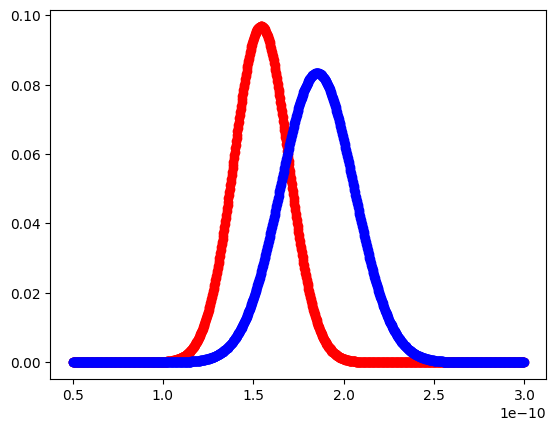

In [13]:
#plt.plot(x, V_x)
plt.plot(x[1:1000], -vecs[:,0], 'ro')
plt.plot(x[1:1000], vecs_e[:,0], 'bo')

## Franck-Condon Factor Calculation

In [23]:
#number of states + 1
states = 6
psi_g = np.zeros((1, states))
psi_LP = np.zeros((1, states))
FCF_int = np.zeros((states, states))
for i in range(states):
    for j in range(states):
        FCF_int[i,j] = np.trapz(vecs[:,i] * vecs_UP[:,j]) 
        FCF = np.absolute(FCF_int) ** 2 
print(FCF)

[[0.30616165 0.35293386 0.21263346 0.08901969 0.02906409 0.00787684]
 [0.37162138 0.01028328 0.11010937 0.22061859 0.1670395  0.08026533]
 [0.21605998 0.13158154 0.1356569  0.00121597 0.11730666 0.17949162]
 [0.07999773 0.25115016 0.00472839 0.16022141 0.03469202 0.02772938]
 [0.02115133 0.16756585 0.16027661 0.02567009 0.09313496 0.09572919]
 [0.0042434  0.06510915 0.20655575 0.0577318  0.08877106 0.02447559]]
